In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import math
from pymongo import MongoClient
import scipy
from statsmodels.stats.power import GofChisquarePower
from statsmodels.stats.contingency_tables import Table2x2

In [2]:
df = pd.read_excel(r"C:\Users\hp\WorldQuantum\7) A-B Testing\Wq-TestInfo-AB.xlsx")
print("data types:", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   _id                  5025 non-null   object        
 1   firstName            5025 non-null   object        
 2   lastName             5025 non-null   object        
 3   email                5025 non-null   object        
 4   birthday             5025 non-null   datetime64[ns]
 5   gender               5025 non-null   object        
 6   highestDegreeEarned  5025 non-null   object        
 7   countryISO2          5018 non-null   object        
 8   admissionsQuiz       5025 non-null   object        
 9   createdAt            5025 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(8)
memory usage: 392.7+ KB
data types: None


In [3]:
df.head()

,_id,firstName,lastName,email,birthday,gender,highestDegreeEarned,countryISO2,admissionsQuiz,createdAt
0,6525d787953844722c8383f8,Terry,Hassler,terry.hassler28@yahow.com,1998-04-29,male,Bachelor's degree,GB,incomplete,2022-05-13 15:02:44
1,6525d787953844722c8383f9,Alan,Noble,alan.noble91@hotmeal.com,1999-03-03,male,Bachelor's degree,NG,complete,2022-05-23 10:36:56
2,6525d787953844722c8383fa,Ruth,Vedovelli,ruth.vedovelli46@microsift.com,1994-08-16,female,Master's degree,ZM,incomplete,2022-05-11 09:35:39
3,6525d787953844722c8383fb,Jennifer,Mayer,jennifer.mayer25@gmall.com,1984-11-23,female,Bachelor's degree,NG,complete,2022-05-16 08:31:34
4,6525d787953844722c8383fc,Ray,Hersey,ray.hersey99@hotmeal.com,1990-10-15,male,Master's degree,PK,complete,2022-05-02 15:14:39


## Calculate Power

One of a Data Scientist's jobs is to help others determine what's  meaningful information and what's not. You can think about this as distinguishing between **signal** and **noise**. As the author [Nate Silver](https://en.wikipedia.org/wiki/The_Signal_and_the_Noise) puts it, "The signal is the truth. The noise is what distracts us from the truth."

In our experiment, we're looking for a signal indicating that applicants who receive an email are more likely to complete the admissions quiz. If signal's strong, it'll be easy to see. A much higher number of applicants in our treatment group will complete the quiz. But if the signal's weak and there's only a tiny change in quiz completion, it will be harder to determine if this is a meaningful difference or just random variation. How can we separate signal from noise in this case? The answer is **statistical power**.

To understand what statistical power is, let's imagine that we're radio engineers building an antenna. The size of our antenna would depend on the type of signal we wanted to detect. It would be OK to build a low-power antenna if we only wanted to detect strong signals, like a car antenna that picks up your favorite local music station. But our antenna wouldn't pick up weaker signals — like a radio station on the other side of the globe. For weaker signals, we'd need something with higher power. In statistics, power comes from the number of observations you include in your experiment. In other words, the more people we include, the stronger our antenna, and the better we can detect weak signals. 

To determine exactly how many people we should include in our study, we need to do a **power calculation**. 

**Task 7.3.2:** First, instantiate a `GofChisquarePower` object and assign it to the variable name `chi_square_power`. Then use it to calculate the `group_size` needed to detect an effect size of `0.2`, with an alpha of `0.05` and power of `0.8`.

- [What's statistical power?](../%40textbook/20-statistics.ipynb#Power)
- [What's effect size?](../%40textbook/20-statistics.ipynb#Effect-Size)
- [Perform a power calculation using statsmodels.](../%40textbook/20-statistics.ipynb#Test-for-Independence)

In [4]:
chi_square_power = GofChisquarePower()
group_size = math.ceil(
    chi_square_power.solve_power(effect_size=0.2, alpha=0.05, power=0.80)
)
print("Group Size:", group_size)
print("Total # of applicants needed:", group_size * 2)

Group Size: 197
Total # of applicants needed: 394


The results here are telling us that if we want to detect an effect size of 0.2 we need a group size of about 200 people. Since our experiment has two conditions (treatment and control, or email and no email), that means we need a total of about 400 applicants in our experiment.

But what about detecting other effect sizes? If we needed to detect a *larger* effect size, we'd need *fewer* applicants. If we needed to detect a *smaller* effect size, we'd need *more* applicants. One way to visualize the relationship between effect size, statistical power, and number of applicants is to make a graph.

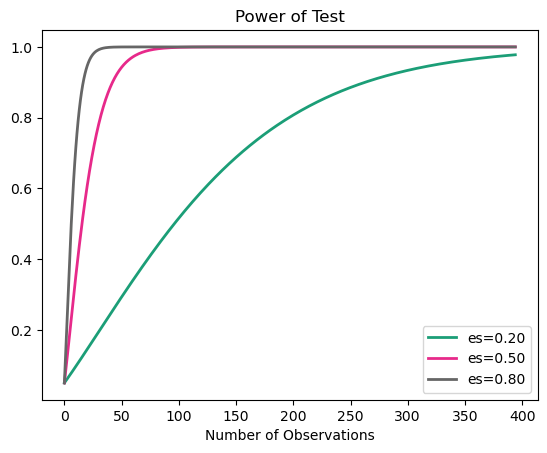

In [5]:
n_observations = np.arange(0, group_size * 2 + 1)
effect_sizes = np.array([0.2, 0.5, 0.8])

# Plot power curve using `chi_square_power`
chi_square_power.plot_power(
    dep_var="nobs",
    nobs=n_observations,
    effect_size=effect_sizes,
    alpha=0.05,
    n_bins=2
);

## Calculate Subjects per Day

In the previous lesson, we decided that our experiment would focus on the subset of applicants who don't take the admissions quiz immediately after creating an account. We know we need around 400 observations from this subset, but how long do we need to run our experiment for in order to get that number?

To answer that question, we first need to calculate how many such applicants open an account each day.

In [6]:
# Step 1: Filter rows where admissionsQuiz is "incomplete"
filtered_df = df[df["admissionsQuiz"] == "incomplete"]

# Step 2: Convert createdAt to datetime
filtered_df["createdAt"] = pd.to_datetime(filtered_df["createdAt"])

# Step 3: Group by the date part of createdAt and count the occurrences
result = filtered_df.groupby(filtered_df["createdAt"].dt.date).size().reset_index(name='count')

# Display the result
print(result)

     createdAt  count
0   2022-05-01     37
1   2022-05-02     49
2   2022-05-03     43
3   2022-05-04     48
4   2022-05-05     47
5   2022-05-06     47
6   2022-05-07     46
7   2022-05-08     60
8   2022-05-09     33
9   2022-05-10     41
10  2022-05-11     36
11  2022-05-12     55
12  2022-05-13     51
13  2022-05-14     44
14  2022-05-15     30
15  2022-05-16     38
16  2022-05-17     42
17  2022-05-18     43
18  2022-05-19     39
19  2022-05-20     41
20  2022-05-21     39
21  2022-05-22     50
22  2022-05-23     49
23  2022-05-24     50
24  2022-05-25     46
25  2022-05-26     40
26  2022-05-27     43
27  2022-05-28     40
28  2022-05-29     39
29  2022-05-30     42


C:\Users\hp\AppData\Local\Temp\ipykernel_18140\3555889600.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["createdAt"] = pd.to_datetime(filtered_df["createdAt"])


In [7]:
# Assuming 'result' is the DataFrame from the previous task
no_quiz = (
    pd.DataFrame(result)
    .rename({"createdAt": "date", "count": "new_users"}, axis=1)  # Rename columns
    .set_index("date")                                            # Set "date" as the index
    .sort_index()                                                 # Sort by date
    .squeeze()                                                    # Convert to a Series
)

# Print type and shape
print("no_quiz type:", type(no_quiz))
print("no_quiz shape:", no_quiz.shape)

# Display the first few rows
no_quiz.head()

no_quiz type: <class 'pandas.core.series.Series'>
no_quiz shape: (30,)


date
2022-05-01    37
2022-05-02    49
2022-05-03    43
2022-05-04    48
2022-05-05    47
Name: new_users, dtype: int64

Okay! Let's see what we've got here by creating a histogram.

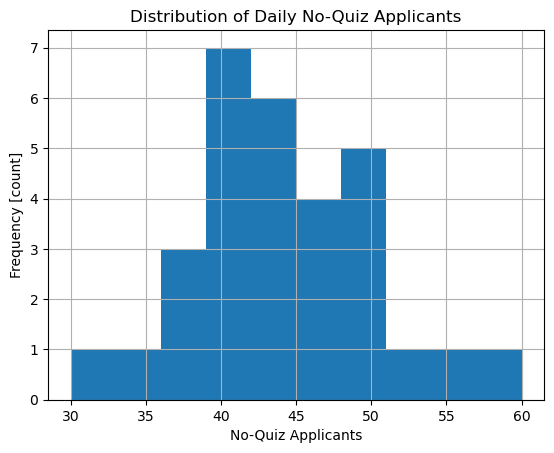

In [8]:
# Create histogram of `no_quiz`
no_quiz.hist()
# Add axis labels and title
plt.xlabel("No-Quiz Applicants")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Daily No-Quiz Applicants");

We can see that somewhere between 30–60 no-quiz applicants come to the site every day. But how can we use this information to ensure that we get our 400 observations? We need to calculate the mean and standard deviation of this distribution.

In [9]:
mean = no_quiz.describe()["mean"]
std = no_quiz.describe()["std"]
print("no_quiz mean:", mean)
print("no_quiz std:", std)

no_quiz mean: 43.6
no_quiz std: 6.398275629767974


The mean around 40 and a standard deviation between 7 and 8. Taking those rough numbers as a guide, how many days do we need to run the experiment to make sure we get to 400 users?

Intuitively, you might think the answer is 10 days, because $10 \cdot 40 = 400$. But we can't guarantee that we'll get 40 new users every day. Some days, there will be fewer; some days, more. So how can we estimate how many days we'll need? Statistics!

The distribution we plotted above shows how many no-quiz applicants come to the site *each day*, but we can use that mean and standard deviation to create a new distribution — one for the sum of no-quiz applicants over *several days*. Let's start with our intuition, and create a distribution for 10 days.

In [10]:
days = 10
sum_mean = mean * days
sum_std = std * np.sqrt(days)
print("Mean of sum:", sum_mean)
print("Std of sum:", sum_std)

Mean of sum: 436.0
Std of sum: 20.233124087615032


With this new distribution, we want to know what the probability is that we'll have 400 or more no-quiz applicants after 10 days. We can calculate this using the **cumulative density function** or CDF. The CDF will give us the probability of having 400 or fewer no-quiz applicants, so we'll need to subtract our result from 1.

In [13]:
prob_400_or_fewer = scipy.stats.norm.cdf(
    group_size * 2,
    loc=sum_mean,
    scale=sum_std
)
prob_400_or_greater = 1 - prob_400_or_fewer

print(
    f"Probability of getting 400+ no_quiz in {days} days:",
    round(prob_400_or_greater, 3),
)

Probability of getting 400+ no_quiz in 10 days: 0.981


Again, the exact probability will change every time we regenerate the database, but there should be around a 90% chance that we'll get the number of applicants we need over 10 days. 

Since we're talking about finding an optimal timeframe, though, try out some other possibilities. Try changing the value of `days` and see what happens.

# Running the Experiment

Okay, now we know how many applicants we need and what the timeframe needs to be. Let's actually run the experiment!

In [16]:
class DataFrameExperiment:
    def __init__(self, df):
        """
        Initialize the experiment with a DataFrame.
        """
        self.df = df

    def reset_experiment(self):
        """
        Reset the experiment by filtering only incomplete admissions.
        """
        self.filtered_df = self.df[self.df["admissionsQuiz"] == "incomplete"].copy()
        self.filtered_df["createdAt"] = pd.to_datetime(self.filtered_df["createdAt"])
        print("Experiment reset: Filtered incomplete admissions.")

    def run_experiment(self, days):
        """
        Simulate running the experiment over a given number of days.
        Args:
            days (int): Number of days for the experiment.

        Returns:
            dict: Simulated MongoDB-like output with acknowledgment and inserted count.
        """
        # Step 1: Group data by date and count new users
        result = (
            self.filtered_df
            .groupby(self.filtered_df["createdAt"].dt.date)
            .size()
            .reset_index(name="new_users")
            .rename(columns={"createdAt": "date"})
            .set_index("date")
            .sort_index()
        )

        # Step 2: Limit to the specified number of days
        if days > len(result):
            print(f"Warning: Only {len(result)} days of data available. Using all available data.")
            days = len(result)

        # Step 3: Calculate mean and standard deviation
        mean_new_users = result["new_users"].mean()
        std_new_users = result["new_users"].std()
        sum_mean = mean_new_users * days
        sum_std = std_new_users * np.sqrt(days)

        print(f"Mean new users for {days} days: {sum_mean}")
        print(f"Standard deviation for {days} days: {sum_std}")

        # Step 4: Create MongoDB-like output
        output = {
            'acknowledged': True,
            'inserted_count': len(result)  # Number of unique dates
        }

        return output

# Instantiate and run the experiment
exp = DataFrameExperiment(df)
exp.reset_experiment()
days = 10  # Example number of days
result = exp.run_experiment(days=days)
print("Result type:", type(result))
print(result)

Experiment reset: Filtered incomplete admissions.
Mean new users for 10 days: 436.0
Standard deviation for 10 days: 20.233124087615032
Result type: <class 'dict'>
{'acknowledged': True, 'inserted_count': 30}


After all that work, the actual running of the experiment might seem a little anticlimactic. This is because we automated the process and are working with synthetic data. Let's look at our results?

# Evaluating Experiment Results

After all that work, the actual running of the experiment might seem a little anticlimactic. This is because we automated the process and are working with synthetic data. Let's look at our results?

## Get Data

First, get the data we need by finding just the people who were part of the experiment...

In [22]:
# Example: Create a new 'inExperiment' column based on some condition (e.g., admissionsQuiz is incomplete)
df["inExperiment"] = df["admissionsQuiz"] == "incomplete"

results type: <class 'pandas.core.frame.DataFrame'>
                         _id firstName    lastName  \
0   6525d787953844722c8383f8     Terry     Hassler   
2   6525d787953844722c8383fa      Ruth   Vedovelli   
6   6525d787953844722c8383fe     Wendy        Apel   
12  6525d787953844722c838404    Dwight  Montgomery   
14  6525d787953844722c838406    Sharon        Butt   

                             email   birthday  gender highestDegreeEarned  \
0        terry.hassler28@yahow.com 1998-04-29    male   Bachelor's degree   
2   ruth.vedovelli46@microsift.com 1994-08-16  female     Master's degree   
6           wendy.apel41@yahow.com 1993-01-09  female   Bachelor's degree   
12   dwight.montgomery57@yahow.com 1993-10-22    male   Bachelor's degree   
14       sharon.butt95@hotmeal.com 1996-12-22  female     Master's degree   

   countryISO2 admissionsQuiz           createdAt  inExperiment  
0           GB     incomplete 2022-05-13 15:02:44          True  
2           ZM     incomplet

In [24]:
# Now filter rows where 'inExperiment' is True
results = df[df["inExperiment"] == True]

# Print the type and first few rows of the result
print("results type:", type(results))

results type: <class 'pandas.core.frame.DataFrame'>


In [32]:
# Check the structure of 'result'
print(results)

# Ensure 'result' is in the expected format (list of dictionaries or similar)
if isinstance(results, dict):
    # If it's a dictionary, make sure to wrap it in a list or correct the structure
    results = [results]

# Convert to DataFrame, drop NaN values, and inspect
df1 = pd.DataFrame(results).dropna()

print("df1 type:", type(df1))
print("df1 shape:", df1.shape)
print(df1.head())

                           _id firstName    lastName  \
0     6525d787953844722c8383f8     Terry     Hassler   
2     6525d787953844722c8383fa      Ruth   Vedovelli   
6     6525d787953844722c8383fe     Wendy        Apel   
12    6525d787953844722c838404    Dwight  Montgomery   
14    6525d787953844722c838406    Sharon        Butt   
...                        ...       ...         ...   
5007  6525d787953844722c839787     Edgar        Reed   
5011  6525d787953844722c83978b    Joseph      Allman   
5013  6525d787953844722c83978d  Jonathan        Mayo   
5020  6525d787953844722c839794    Victor     Collins   
5023  6525d787953844722c839797   Florine      Thomas   

                               email   birthday  gender  \
0          terry.hassler28@yahow.com 1998-04-29    male   
2     ruth.vedovelli46@microsift.com 1994-08-16  female   
6             wendy.apel41@yahow.com 1993-01-09  female   
12     dwight.montgomery57@yahow.com 1993-10-22    male   
14         sharon.butt95@hotmeal

## Build Contingency Table

Now that the results are in a DataFrame, we can start pulling apart what we found. Let's start by making a table showing how many people did and didn't complete the quiz across our two groups.

In [36]:
pd.crosstab(df['inExperiment'], df['admissionsQuiz'])


admissionsQuiz,complete,incomplete
inExperiment,,
False,3717,0
True,0,1308


In [35]:
print(df.columns)


Index(['_id', 'firstName', 'lastName', 'email', 'birthday', 'gender',
       'highestDegreeEarned', 'countryISO2', 'admissionsQuiz', 'createdAt',
       'inExperiment'],
      dtype='object')


In [37]:
data = pd.crosstab(
    index=df["group"],
    columns=df["admissionsQuiz"],
    normalize=False
)
print("data type:", type(data))
print("data shape:", data.shape)
data

KeyError: 'group'

In [38]:
def build_contingency_bar():
    # Create side-by-side bar chart
    fig = px.bar(
        data_frame=data,
        barmode="group",
        title="Admissions Quiz Completion by Group"
    )
    # Set axis labels
    fig.update_layout(
        xaxis_title="Group",
        yaxis_title="Frequency [count]",
        legend={"title": "Admissions Quiz"}
    )
    return fig


build_contingency_bar().show()

NameError: name 'data' is not defined

Without doing anything else, we can see that people who got an email actually did complete the quiz more often than people who didn't. So can we conclude that, as a general rule, applicants who receive an email are more likely to complete quiz. No, not yet. After all, the difference we see could be due to chance. 

In order to determine if this difference is more than random variation, we need to take our results, put them into a **contingency table**, and run a statistical test.

In [39]:
contingency_table = Table2x2(data.values)

print("contingency_table type:", type(contingency_table))
contingency_table.table_orig

NameError: name 'data' is not defined

## Conduct Chi-Square Test

Here's where the rubber meets the road: all the previous calculations have shown us that some of the people who got an email went on to complete the quiz, but we don't know what might be driving that effect. After all, some people might be responding to getting an email, but others might have finished the quiz whether we emailed them or not. Either way, the effect we found could just as easily be due to chance as it could be a result of something we did. The only way to find out whether the result is due to chance is to calculate statistical significance.

There are several ways to do this, but since the rows and columns here are unordered (nominal factors), we can do a chi-square test.